# Plot flight data

Import the modules we need to load and plot the flight data.

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Flight data are all collected at different times. Analysis is more convenient if we first *resample* the flight data so it is as if these data were all collected at the same times.

Here is a function that loads and resamples the flight data at 100 Hz, using linear interpolation. It returns the resampled flight data in the form of a dictionary, where each item is a numpy array.

In [19]:
def resample(filename):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

Load and resample the flight data.

In [20]:
data = resample('logged_data.json')

Extract time, position, and orientation (converting angles from degrees to radians).

In [21]:
t = data['time']
x = data['stateEstimate.x']
y = data['stateEstimate.y']
z = data['stateEstimate.z']
yaw = np.deg2rad(data['stateEstimate.yaw'])
pitch = - np.deg2rad(data['stateEstimate.pitch']) # <-- think: why the change in sign?
roll = np.deg2rad(data['stateEstimate.roll'])

Plot position and orientation as a function of time.

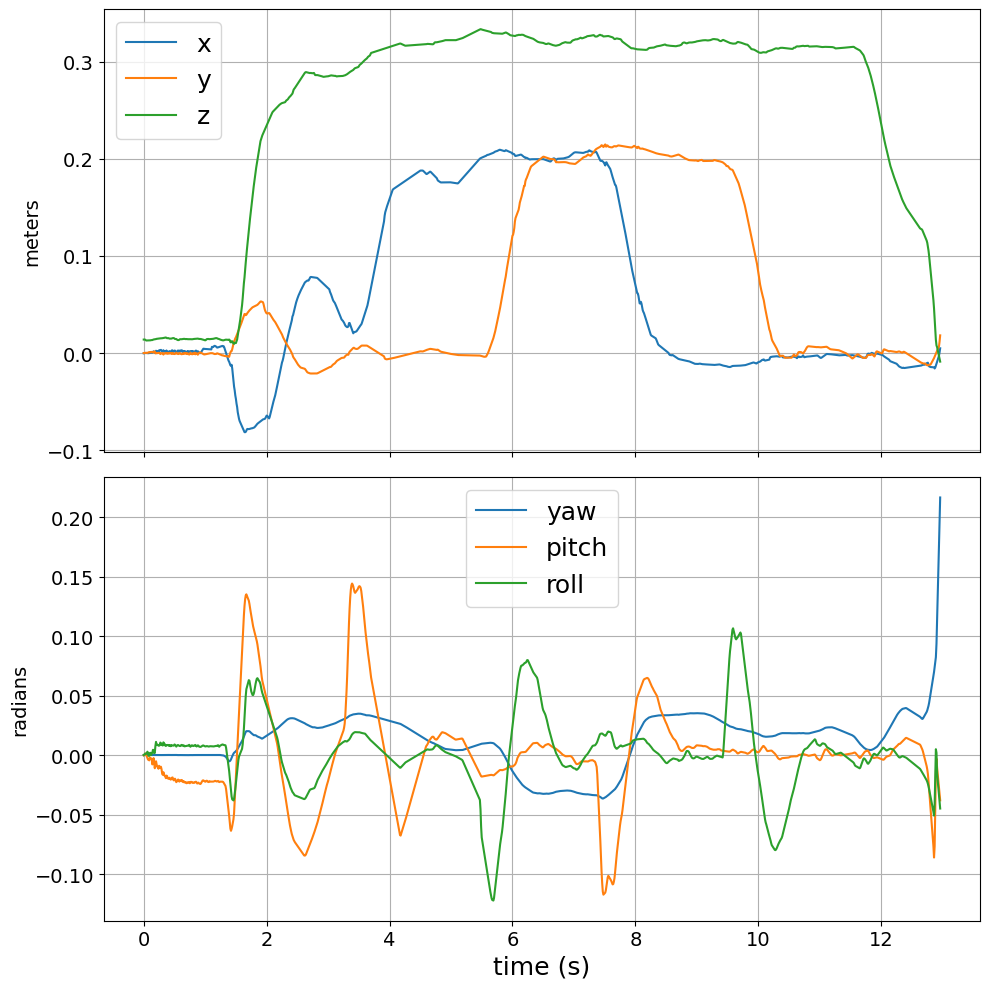

In [22]:
fig, (ax_pos, ax_ori) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax_pos.plot(t, x, label='x')
ax_pos.plot(t, y, label='y')
ax_pos.plot(t, z, label='z')
ax_pos.legend(fontsize=18)
ax_pos.grid()
ax_pos.tick_params(labelsize=14)
ax_pos.set_ylabel('meters', fontsize=14)
ax_ori.plot(t, yaw, label='yaw')
ax_ori.plot(t, pitch, label='pitch')
ax_ori.plot(t, roll, label='roll')
ax_ori.legend(fontsize=18)
ax_ori.grid()
ax_ori.set_ylabel('radians', fontsize=14)
ax_ori.set_xlabel('time (s)', fontsize=18)
ax_ori.tick_params(labelsize=14)
fig.tight_layout()

# Visualize flight data

Import the extra modules we need for visualization.

In [23]:
import time

# This is my own script (it is an interface to the pybullet simulator)
import ae483_drone

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae483_drone)

<module 'ae483_drone' from 'C:\\Users\\amirn\\OneDrive\\Documents\\UIUC-FA_23\\AE483\\crazyflie-client\\lab02\\ae483_drone.py'>

Start the simulator.

In [24]:
simulator = ae483_drone.Simulator(width=640, height=480)

Replay the flight in the simulator, in real-time.

In [25]:
start_time = time.time()
for i in range(len(t)):
    while (time.time() - start_time) < t[i]:
        time.sleep(0.001)
    simulator.set_pose(x[i], y[i], z[i], yaw[i], pitch[i], roll[i])

Take a snapshot at a particular time step.

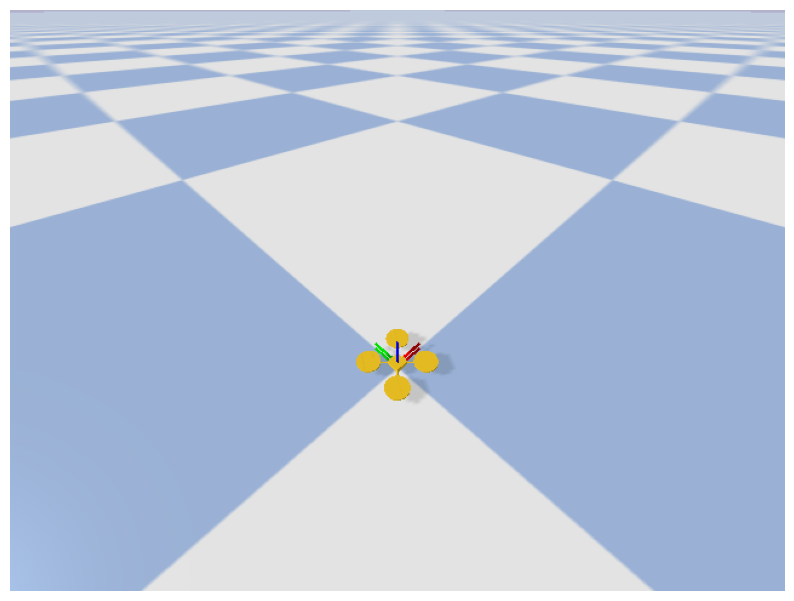

In [31]:
# Choose a time step
i = 0

# Put the drone where it was at this time step
simulator.set_pose(x[i], y[i], z[i], yaw[i], pitch[i], roll[i])

# Get snapshot
rgba = simulator.snapshot()

# Show snapshot
fig = plt.figure(figsize=(10, 10))
plt.imshow(rgba)
plt.axis('off')

# Save snapshot
plt.imsave('snapshot.png', rgba)